<p style="text-align:center">
    <a href="https://skills.network" target="_blank">
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/assets/logos/SN_web_lightmode.png" width="200" alt="Skills Network Logo">
    </a>
</p>


<h1>Neural Networks with One Hidden Layer</h1>


<h2>Objective</h2><ul><li> How to classify handwritten digits using Neural Network.</li></ul> 


<h2>Table of Contents</h2>
<p>In this lab, you will use a single layer neural network to classify handwritten digits from the MNIST database.</p>

<ul>
    <li><a href="#Model">Neural Network Module and Training Function</a></li>
    <li><a href="#Makeup_Data">Make Some Data</a></li>
    <li><a href="#Train">Define the Neural Network, Optimizer, and Train the  Model</a></li>
    <li><a href="#Result">Analyze Results</a></li>
</ul>
<p>Estimated Time Needed: <strong>25 min</strong></p>

<hr>


<h2>Preparation</h2>


We'll need the following libraries


In [1]:
%%time
%pip install pandas numpy matplotlib
%pip install torch==2.8.0+cpu torchvision==0.23.0+cpu torchaudio==2.8.0+cpu \
    --index-url https://download.pytorch.org/whl/cpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 168.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.6/16.6 MB 189.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 156.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 91.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 82.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 144.4 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.
Looking in indexes: https://download.pytorch.org/whl/cpu
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.2/536.2 kB 16.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 MB 40.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 1.9 MB/s eta 0:00:00eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 61.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 45.3 MB/s eta 0:

In [2]:
# Import the libraries we need for this lab

# Using the following line code to install the torchvision library
# !mamba install -y torchvision

import torch 
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
import torch.nn.functional as F
import matplotlib.pylab as plt
import numpy as np

Matplotlib is building the font cache; this may take a moment.


Use the following helper functions for plotting the loss: 


In [3]:
# Define a function to plot accuracy and loss

def plot_accuracy_loss(training_results): 
    plt.subplot(2, 1, 1)
    plt.plot(training_results['training_loss'], 'r')
    plt.ylabel('loss')
    plt.title('training loss iterations')
    plt.subplot(2, 1, 2)
    plt.plot(training_results['validation_accuracy'])
    plt.ylabel('accuracy')
    plt.xlabel('epochs')   
    plt.show()

Use the following function for printing the model parameters: 


In [4]:
# Define a function to plot model parameters

def print_model_parameters(model):
    count = 0
    for ele in model.state_dict():
        count += 1
        if count % 2 != 0:
            print ("The following are the parameters for the layer ", count // 2 + 1)
        if ele.find("bias") != -1:
            print("The size of bias: ", model.state_dict()[ele].size())
        else:
            print("The size of weights: ", model.state_dict()[ele].size())

Define the neural network module or class: 


In [5]:
# Define a function to display data

def show_data(data_sample):
    plt.imshow(data_sample.numpy().reshape(28, 28), cmap='gray')
    plt.show()

<!--Empty Space for separating topics-->


<a name="Model"><h2 id="Model">Neural Network Module and Training Function</h2></a>


Define the neural network module or class: 


In [6]:
# Define a Neural Network class

class Net(nn.Module):
    
    # Constructor
    def __init__(self, D_in, H, D_out):
        super(Net, self).__init__()
        self.linear1 = nn.Linear(D_in, H)
        self.linear2 = nn.Linear(H, D_out)

    # Prediction    
    def forward(self, x):
        x = torch.sigmoid(self.linear1(x))  
        x = self.linear2(x)
        return x

Define a function to train the model. In this case, the function returns a Python dictionary to store the training loss and accuracy on the validation data. 


In [7]:
# Define a training function to train the model

def train(model, criterion, train_loader, validation_loader, optimizer, epochs=100):
    i = 0
    useful_stuff = {'training_loss': [],'validation_accuracy': []}  
    for epoch in range(epochs):
        for i, (x, y) in enumerate(train_loader): 
            optimizer.zero_grad()
            z = model(x.view(-1, 28 * 28))
            loss = criterion(z, y)
            loss.backward()
            optimizer.step()
             #loss for every iteration
            useful_stuff['training_loss'].append(loss.data.item())
        correct = 0
        for x, y in validation_loader:
            #validation 
            z = model(x.view(-1, 28 * 28))
            _, label = torch.max(z, 1)
            correct += (label == y).sum().item()
        accuracy = 100 * (correct / len(validation_dataset))
        useful_stuff['validation_accuracy'].append(accuracy)
    return useful_stuff

<!--Empty Space for separating topics-->


<a name="Makeup_Data"><h2 id="Makeup_Data">Make Some Data</h2></a> 


Load the training dataset by setting the parameters <code>train</code> to <code>True</code> and convert it to a tensor by placing a transform object in the argument <code>transform</code>.


In [8]:
# Create training dataset

train_dataset = dsets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())

Load the testing dataset and convert it to a tensor by placing a transform object in the argument <code>transform</code>:


In [9]:
# Create validating dataset

validation_dataset = dsets.MNIST(root='./data', download=True, transform=transforms.ToTensor())

Create the criterion function:  


In [10]:
# Create criterion function

criterion = nn.CrossEntropyLoss()

Create the training-data loader and the validation-data loader objects: 


In [11]:
# Create data loader for both train dataset and valdiate dataset

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=2000, shuffle=True)
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=5000, shuffle=False)

<!--Empty Space for separating topics-->


<a name ="Train"><h2 id="Train">Define the Neural Network, Optimizer, and Train the Model</h2></a> 


Create the model with 100 neurons: 


In [12]:
# Create the model with 100 neurons

input_dim = 28 * 28
hidden_dim = 100
output_dim = 10

model = Net(input_dim, hidden_dim, output_dim)

Print the model parameters: 


In [13]:
# Print the parameters for model

print_model_parameters(model)

The following are the parameters for the layer  1
The size of weights:  torch.Size([100, 784])
The size of bias:  torch.Size([100])
The following are the parameters for the layer  2
The size of weights:  torch.Size([10, 100])
The size of bias:  torch.Size([10])


Define the optimizer object with a learning rate of 0.01: 


In [15]:
# Set the learning rate and the optimizer

learning_rate = 0.01
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

Train the model by using 100 epochs **(this process takes time)**: 


In [16]:
# Train the model

training_results = train(model, criterion, train_loader, validation_loader, optimizer, epochs=30)

<!--Empty Space for separating topics-->


<a name="Result"><h2 id="Result">Analyze Results</h2></a> 


Plot the training total loss or cost for every iteration and plot the training accuracy for every epoch:  


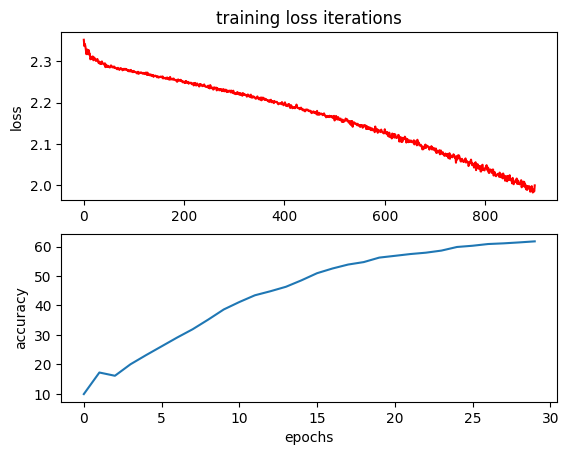

In [17]:
# Plot the accuracy and loss

plot_accuracy_loss(training_results)

Plot the first five misclassified samples:   


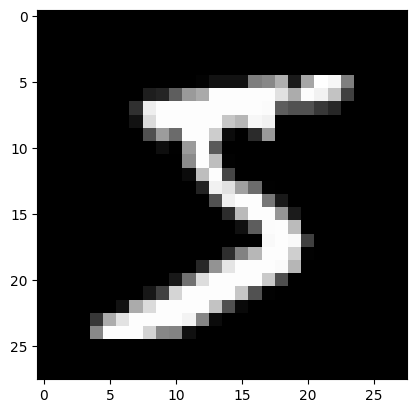

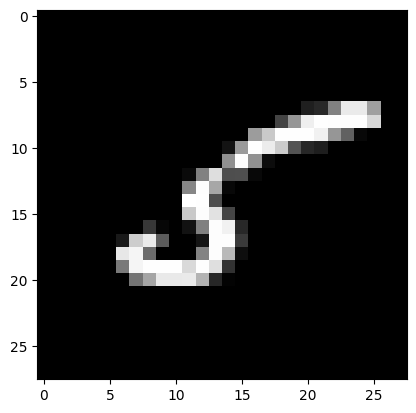

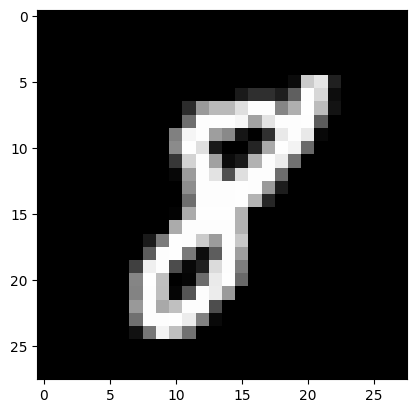

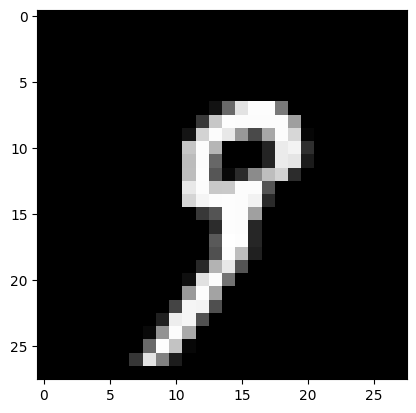

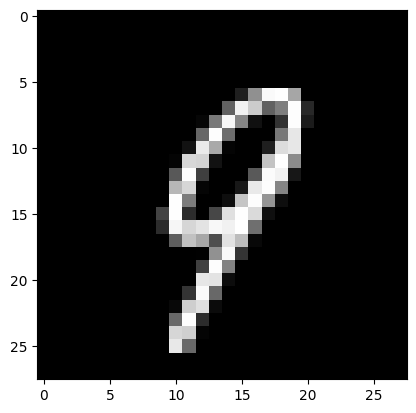

In [18]:
# Plot the first five misclassified samples

count = 0
for x, y in validation_dataset:
    z = model(x.reshape(-1, 28 * 28))
    _,yhat = torch.max(z, 1)
    if yhat != y:
        show_data(x)
        count += 1
    if count >= 5:
        break

<h3>Practice</h3> 


Use <code>nn.Sequential</code> to build exactly the same model as you just built. Use the function <train>train</train> to train the model and use the function <code>plot_accuracy_loss</code> to see the metrics. Also, try different epoch numbers. 


In [21]:
# Practice: Use nn.Sequential to build the same model. Use plot_accuracy_loss to print out the accuarcy and loss

# Type your code here
model = nn.Sequential(
    torch.nn.Linear(input_dim, hidden_dim),
    torch.nn.Sigmoid(),
    torch.nn.Linear(hidden_dim, output_dim)
)
print_model_parameters(model)

The following are the parameters for the layer  1
The size of weights:  torch.Size([100, 784])
The size of bias:  torch.Size([100])
The following are the parameters for the layer  2
The size of weights:  torch.Size([10, 100])
The size of bias:  torch.Size([10])


In [22]:
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

training_results = train(model, criterion, train_loader, validation_loader, optimizer, epochs=30)

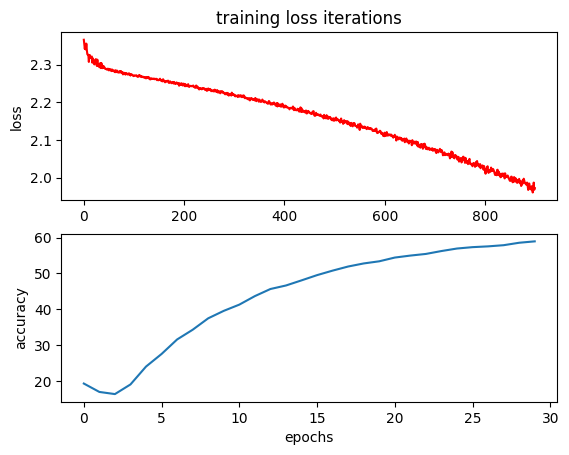

In [23]:
plot_accuracy_loss(training_results)

Double-click <b>here</b> for the solution.

<!-- 
input_dim = 28 * 28
hidden_dim = 100
output_dim = 10

model = torch.nn.Sequential(
    torch.nn.Linear(input_dim, hidden_dim),
    torch.nn.Sigmoid(),
    torch.nn.Linear(hidden_dim, output_dim),
)
learning_rate = 0.01
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)
training_results = train(model, criterion, train_loader, validation_loader, optimizer, epochs = 10)
plot_accuracy_loss(training_results)
-->


<h2>About the Authors:</h2> 

<a href="https://www.linkedin.com/in/joseph-s-50398b136/">Joseph Santarcangelo</a> has a PhD in Electrical Engineering, his research focused on using machine learning, signal processing, and computer vision to determine how videos impact human cognition. Joseph has been working for IBM since he completed his PhD. 


Other contributors: <a href="https://www.linkedin.com/in/michelleccarey/">Michelle Carey</a>, <a href="https://www.linkedin.com/in/jiahui-mavis-zhou-a4537814a">Mavis Zhou</a>


<!--
## Change Log

|  Date (YYYY-MM-DD) |  Version | Changed By  |  Change Description |
|---|---|---|---|
| 2020-09-23  | 2.0  | Shubham  |  Migrated Lab to Markdown and added to course repo in GitLab |
-->


<hr>





## <h3 align="center"> &#169; IBM Corporation. All rights reserved. <h3/>
